In [1]:
# Import pandas, numpy and matplotlib libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

/home/obyrned1/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# (1). Data Understanding: 

### (1.1) Randomly shuffle the rows of your dataset and split the dataset into two datasets: 70% training and 30% test. Keep the test set aside. 

I have commented out the following 6 cells so that a new shuffled test and train set isn't created each time the notebook is run

In [2]:
# I will read in the adjusted data from Homework1
#df = pd.read_csv('adjustedData_CustomerChurn-17205389.csv', sep=',', index_col=0)
#df['churn'].replace(['true'], 1 )
#df['churn'].replace(['false'], 0 )

In [3]:
# shuffle all rows
#shuffle_df = df.sample(frac=1)
#shuffle_df.to_csv('shuffled_CustomerChurn-17205389.csv', sep = ',', index=False)

In [4]:
#df = pd.read_csv('shuffled_CustomerChurn-17205389.csv', sep=',')


In [5]:
#splitting the df into train and test
#train, test = train_test_split(df, test_size=0.3)

In [6]:
#train.to_csv('training_CustomerChurn-17205389.csv', sep=',', index=False)
# save the train df to a csv

In [7]:
#test.to_csv('test_CustomerChurn-17205389.csv', sep=',', index=False)
# save the test df to a csv

In [8]:
train_df = pd.read_csv('training_CustomerChurn-17205389.csv', sep=',')


In [9]:
# Select columns containing categorical data
categorical_columns = train_df[['income', 'regionType','marriageStatus','children','smartPhone',
                          'creditRating','homeOwner','creditCard','churn']].columns

# Convert data type to category for these columns
for column in categorical_columns:
    train_df[column] = train_df[column].astype('category')

# Select columns containing continuous data
continuous_columns = train_df[['age','numHandsets','handsetAge','currentHandsetPrice','avgBill','avgMins',
                         'avgrecurringCharge','avgOverBundleMins','avgRoamCalls','callMinutesChangePct',
                         'billAmountChangePct','avgReceivedMins','avgOutCalls','avgInCalls','peakOffPeakRatio',
                         'peakOffPeakRatioChangePct','avgDroppedCalls','lifeTime','lastMonthCustomerCareCalls',
                         'numRetentionCalls','numRetentionOffersAccepted','newFrequentNumbers']].columns

In [10]:
train_df['churn'] = train_df['churn'].astype('int64')
#train_df.churn

### (1.2) On the training set:
### (a) Plot the correlations between all the continuous features. 

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5]), <a list of 22 Text xticklabel objects>)

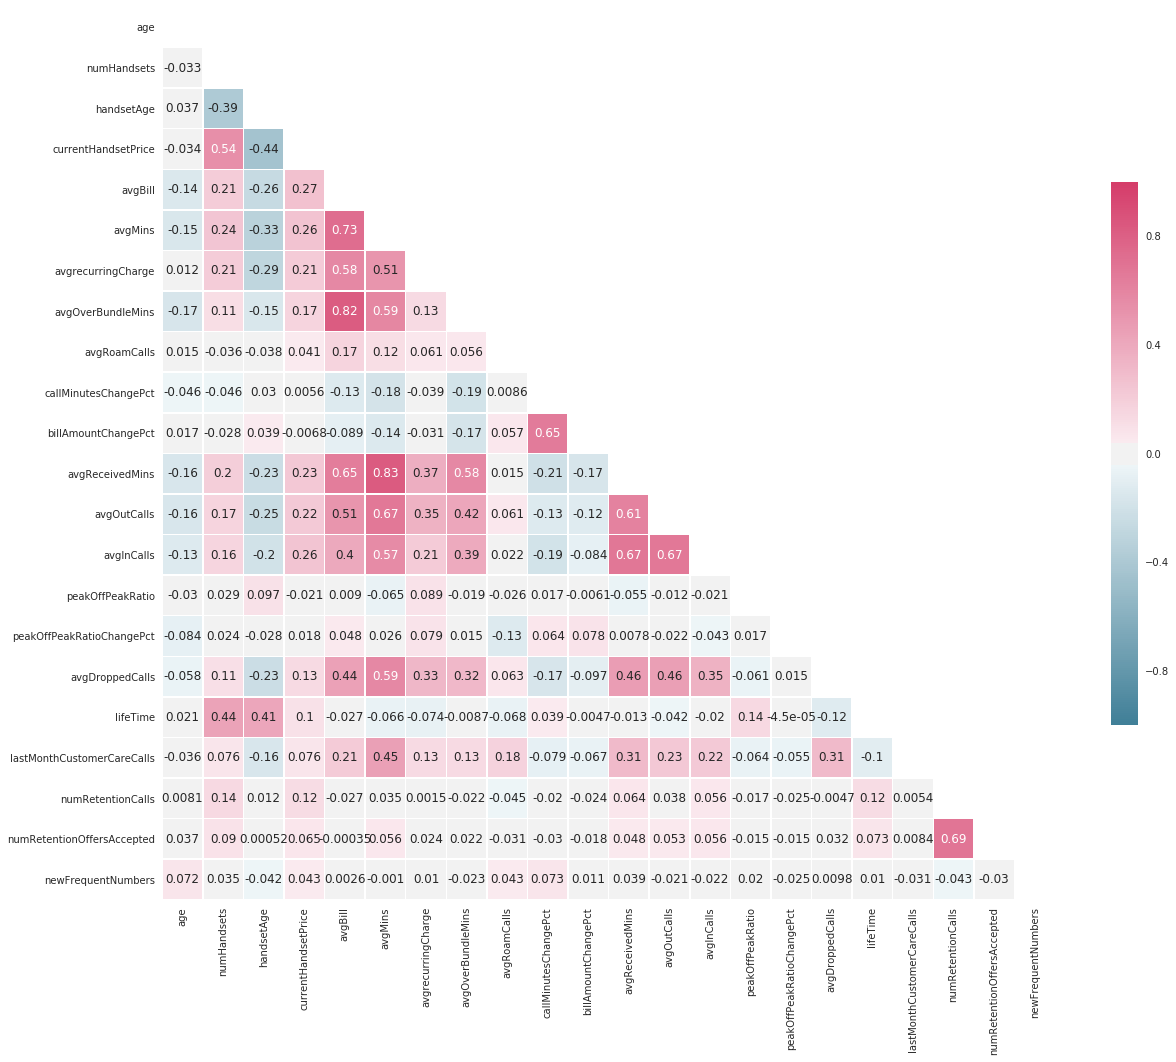

In [11]:
# Plot the correlations between all the continuous features
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = train_df[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(225, 0, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

In [12]:
train_df.groupby('numRetentionCalls')['numRetentionCalls'].apply(lambda x: x.count())

numRetentionCalls
0    667
1     29
2      3
3      1
Name: numRetentionCalls, dtype: int64

In [13]:
train_df.groupby('numRetentionOffersAccepted')['numRetentionOffersAccepted'].apply(lambda x: x.count())

numRetentionOffersAccepted
0    686
1     13
3      1
Name: numRetentionOffersAccepted, dtype: int64

### (b) Discuss what you see in these plots

Given the number of features present in this dataset and the correlations that exists between these continuous features, I have only pinpointed correlations with a value greater than 0.6 or less than -0.6. As there are no correlations that are less than -0.6, all correlations I have deemed significant have a value of greater than 0.6. If I had used a threshold of 0.5, I felt it would have yielded too many relationships to discuss somewhat unnecessarily. 

In total there are 10 strong(above 0.6) positive correlations between these continuous features. Most of these correlations are very intuitive and would be expected given the nature of the features as discussed below.

    - avgMins &:
        avgBill = 0.73
        avgOutCalls = 0.67
        avgReceivedMins = 0.83
It makes sense that a larger number of average minutes correlates strongly these three features. Unless there is significant economies of scale in the customers plan, the more minutes used, the greater the bill will be as seen here. Similarly, the greater the number of call minutes used by the customer (avgMins), it's not suprising to see an increase in the average out calls and received mins, from general usage.

    - avgBill &:
        avgReceivedMins = 0.65
        avgOverBundleMins = 0.82
From the avgMins correlations, we can see the relationship between avgBill and avgReceivedMins, through the avgMins feature. Higher bills will correlate with higher avgMins, which positively correlates with avgReceivedMins. Thus, it is no suprise that avgBill has a 0.65 positive correlation with avgReceivedMin.
A positive correlation between avgBill and avgOverBundleMins of 0.82 also makes sense given that minutes used over those allowed in a customer's bundle, are charged at a higher rate.

    - avgReceivedMins &:
        avgInCalls = 0.67
        avgOutCalls = 0.61
    - avgInCalls & avgOutCalls = 0.67
These three correlations are also intuitive. A customer who uses their phone a lot (high in and out calls), will likely experience a high level of received minutes. Thus, both correlations of 0.67 and 0.61 are justified. Similarly,  a 0.67 positive correlation between in and out calls make sense.

 
    - numRetentionCalls & numRetentionOffersAccepted = 0.69
This strong correlation tells us that for every 1 extra retention call to a customer, 69% of time, a retention offer will be accepted. However, with both of these features containing a high level of 0 values (both over 95% zero values), this correlation is unlikely to hold any meaning in our analysis. 

    - callMinutesChangePct & billAmountChangePct = 0.65
This correlation is likley linked to the average bills and minutes relationships above. This strong correlation is justified as if a customer significanlty changes the number of minutes they use, their bill will change in the same direction (to a 65% magnitude).
               

### (c) For each continuous feature, plot its interaction with the target feature (a plot for each pair of continuous feature and target feature). 

/home/obyrned1/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


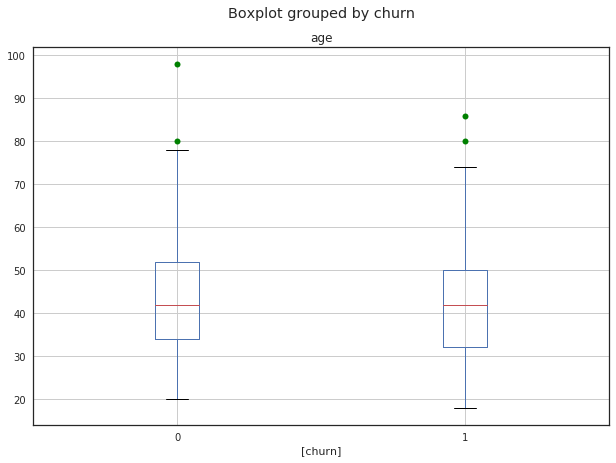

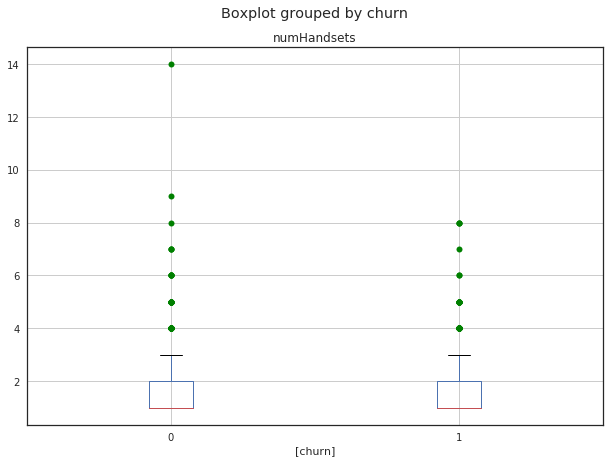

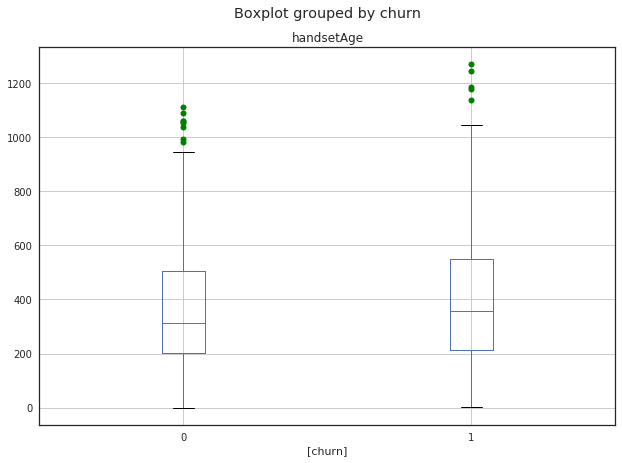

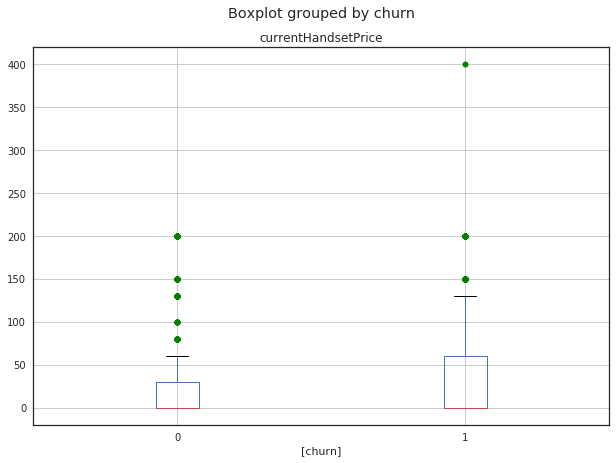

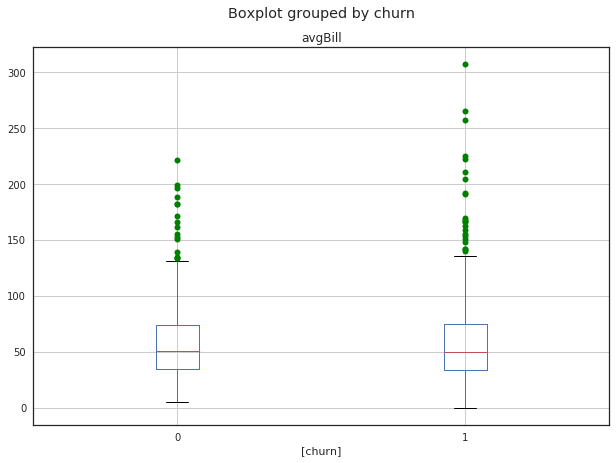

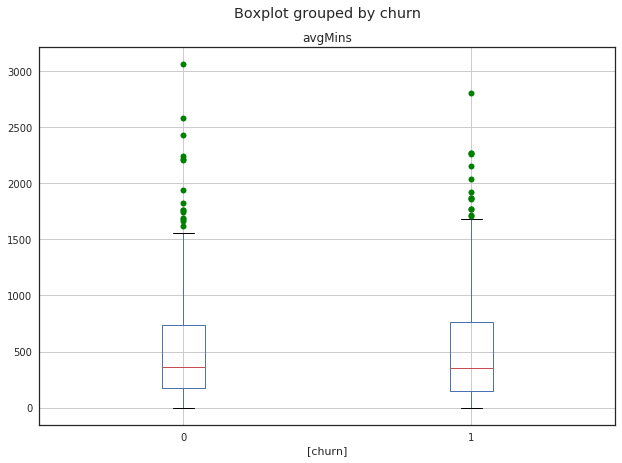

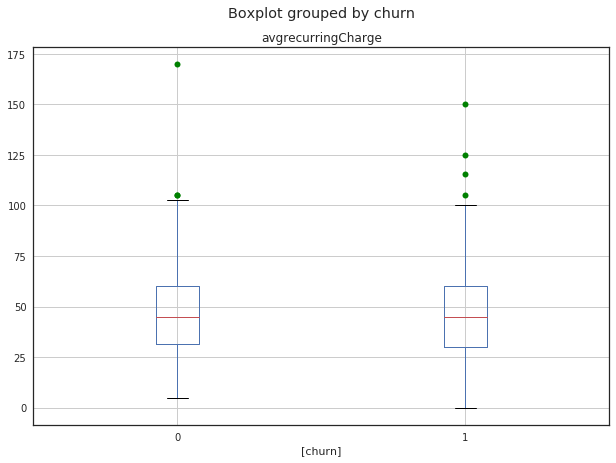

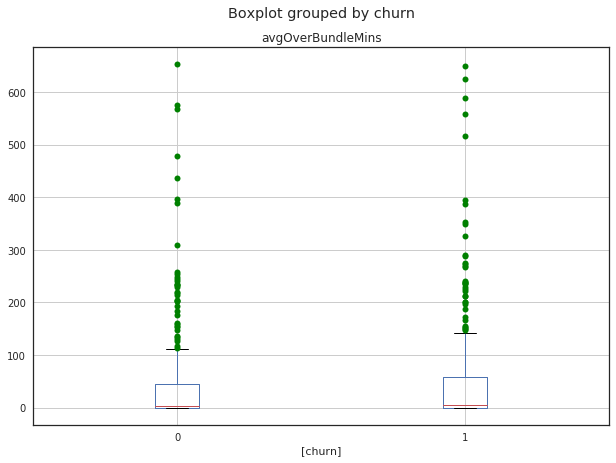

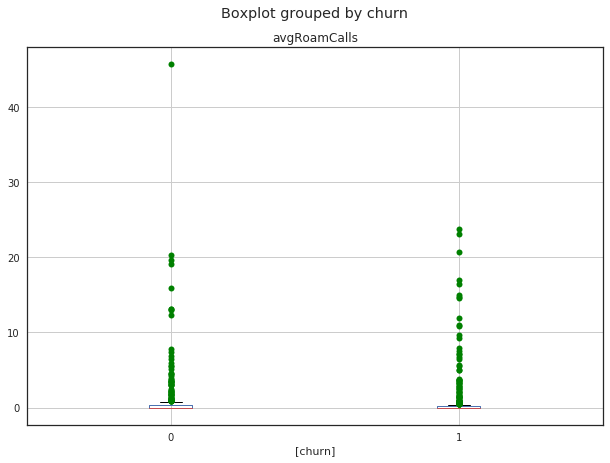

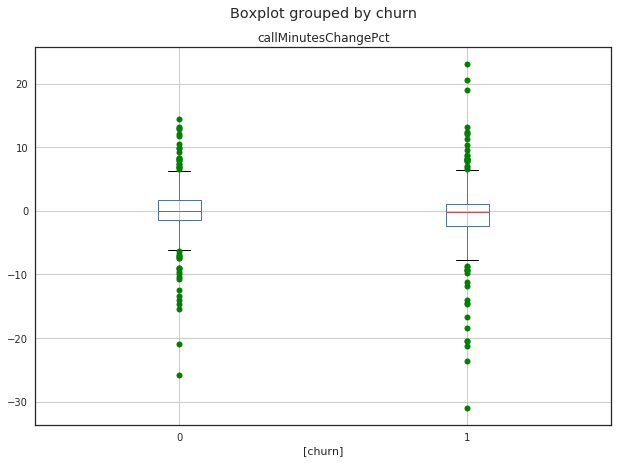

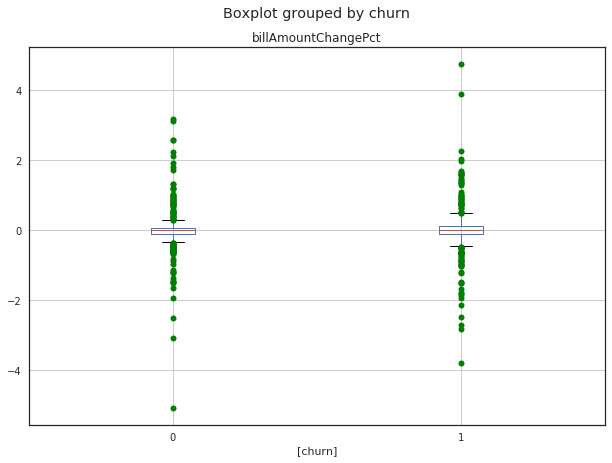

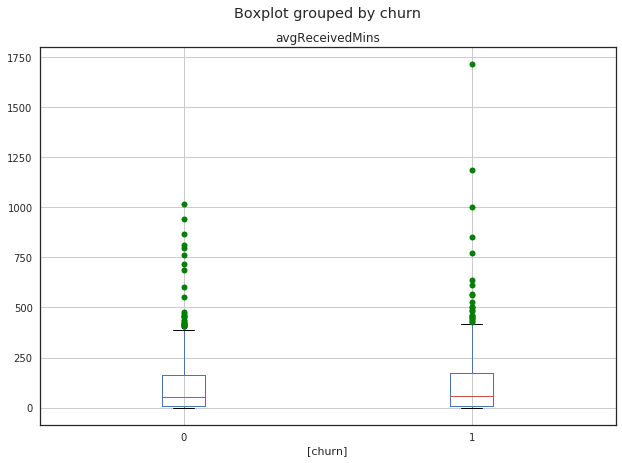

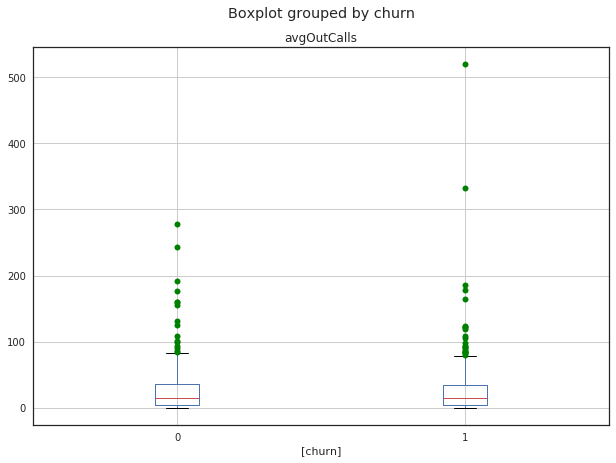

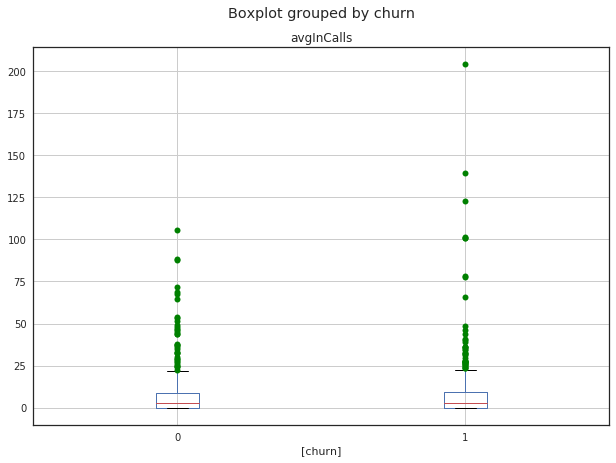

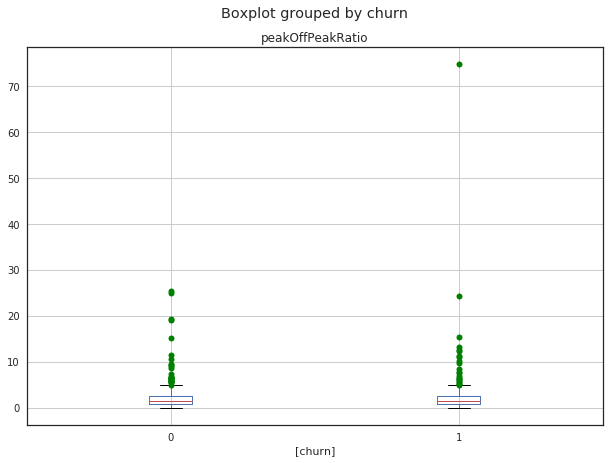

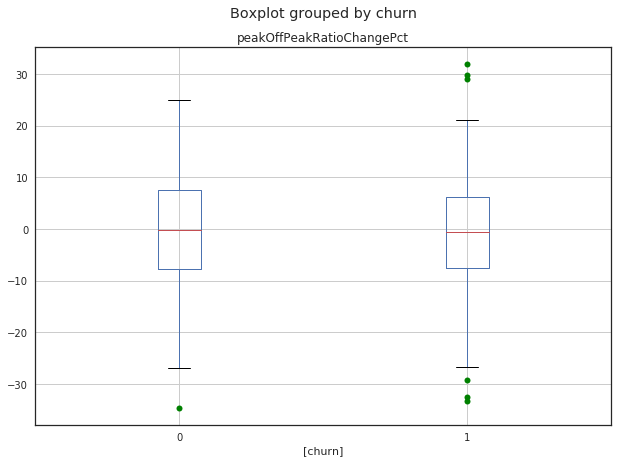

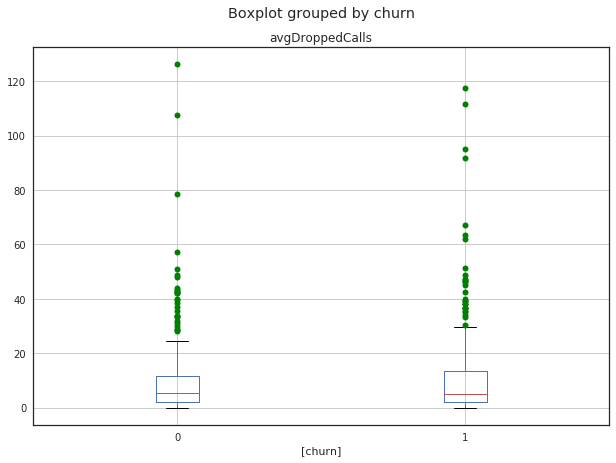

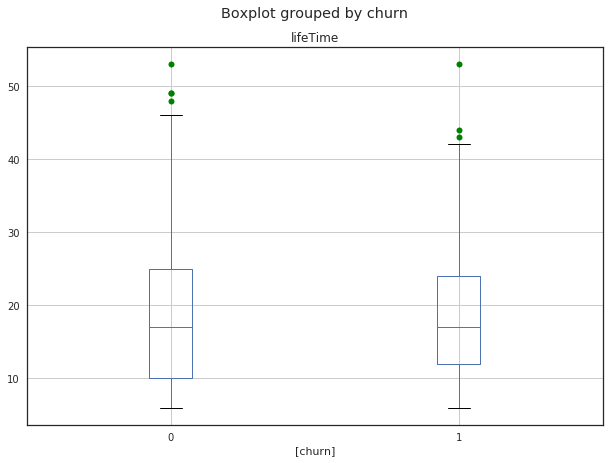

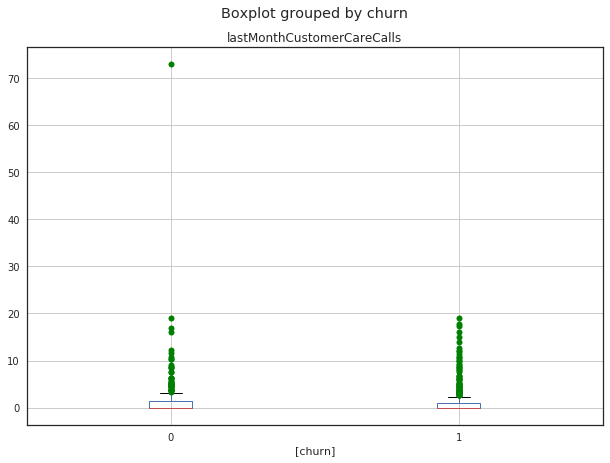

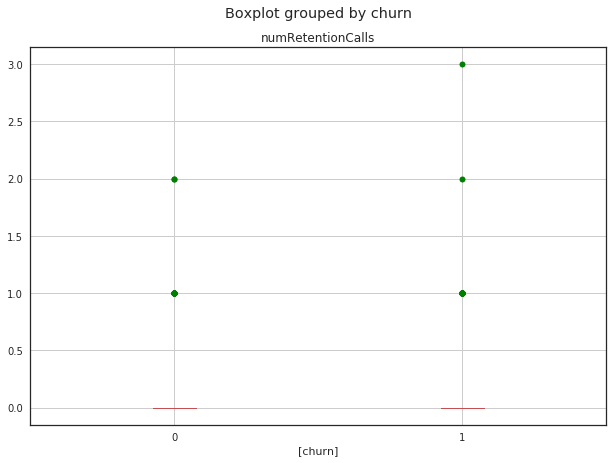

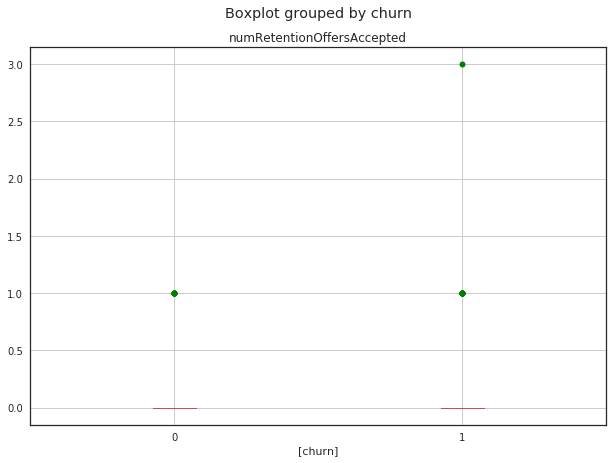

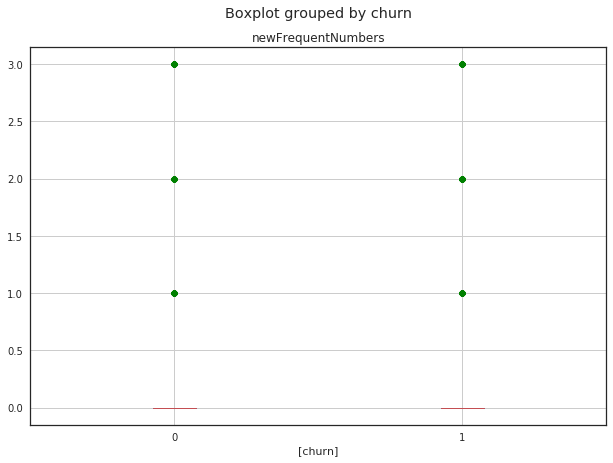

In [14]:
# For each continuous feature, plot its interaction with the target feature (churn)
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
for i in continuous_columns:
    bp = train_df.boxplot(column=[i], by=['churn'], flierprops=flierprops, figsize=(10,7))


/home/obyrned1/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


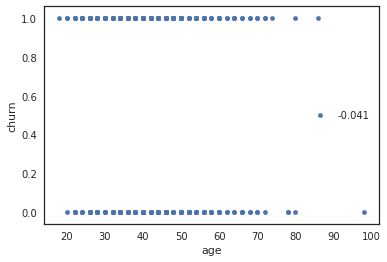

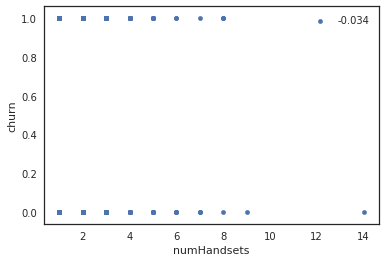

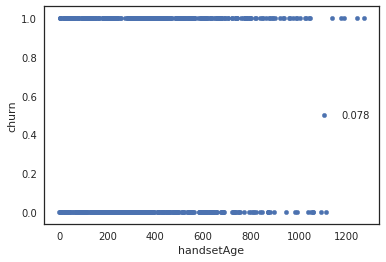

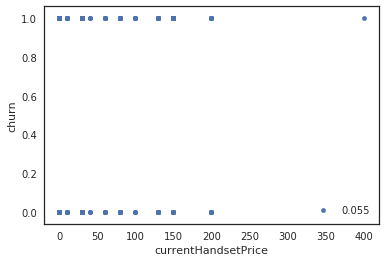

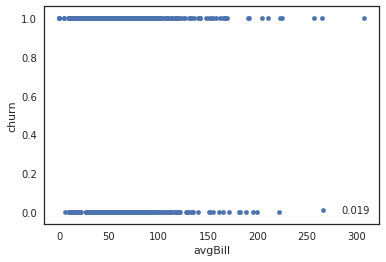

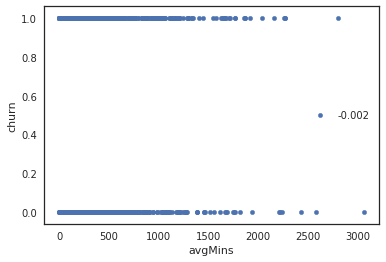

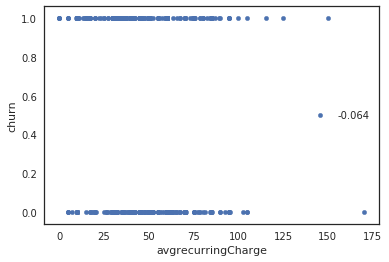

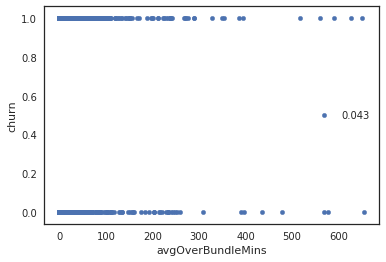

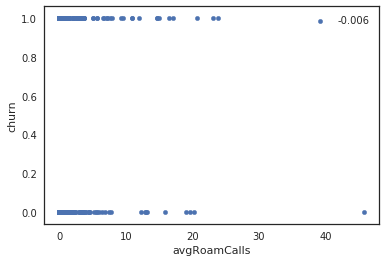

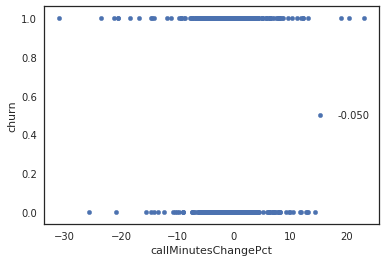

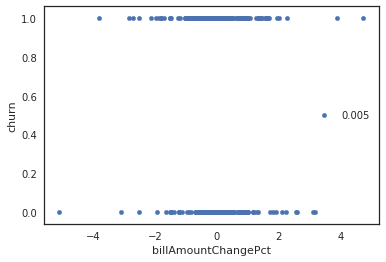

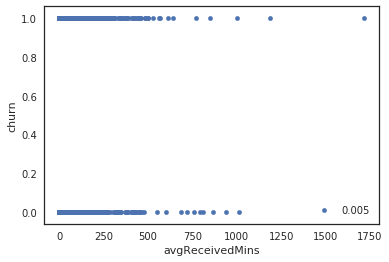

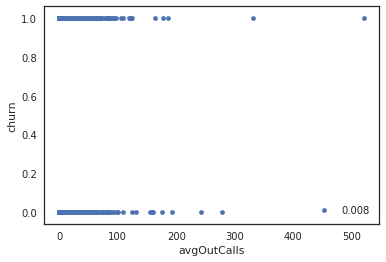

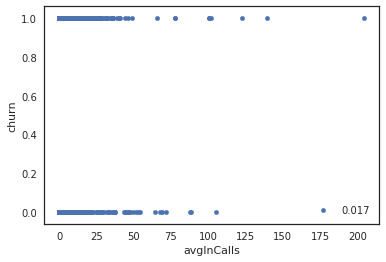

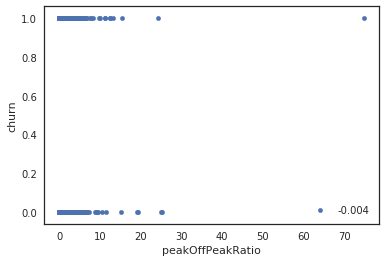

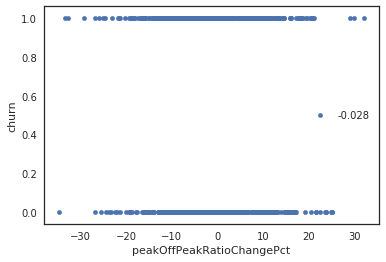

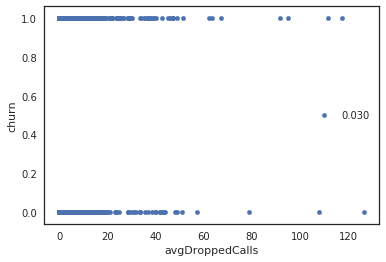

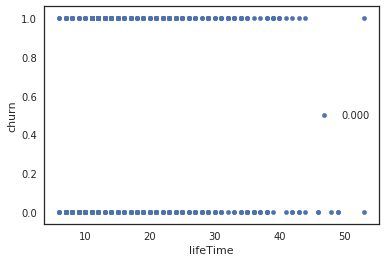

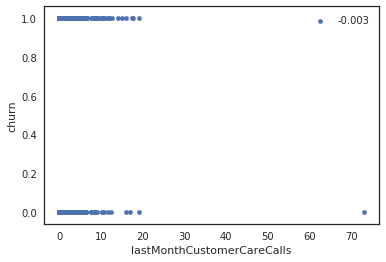

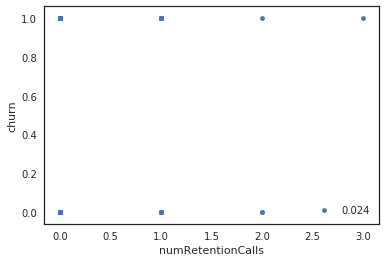

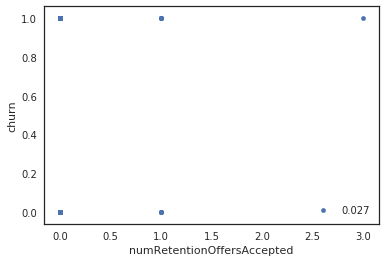

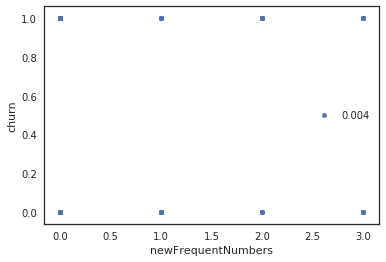

In [15]:
for c in continuous_columns:
    train_df.plot(kind='scatter', x=c , y='churn', label="%.3f" % train_df[[c, 'churn']].corr().as_matrix()[0,1])

In [16]:
train_df.groupby('churn').describe()['handsetAge'].T

churn            0            1
count   336.000000   364.000000
mean    364.758929   403.337912
std     234.616763   258.688339
min       0.000000     3.000000
25%     202.750000   212.000000
50%     311.000000   356.000000
75%     503.250000   549.500000
max    1112.000000  1270.000000

In [17]:
train_df.groupby('churn').describe()['currentHandsetPrice'].T

churn           0           1
count  336.000000  364.000000
mean    33.239732   39.638489
std     53.855445   61.449234
min      0.000000    0.000000
25%      0.000000    0.000000
50%      0.000000    0.000000
75%     29.990000   59.990000
max    199.990000  399.990000

In [18]:
train_df.groupby('currentHandsetPrice')['currentHandsetPrice'].apply(lambda x: x.count())

currentHandsetPrice
0.00      396
9.99       25
29.99      95
39.99       6
59.99      22
79.99      35
99.99      14
129.99     33
149.99     51
199.99     22
399.99      1
Name: currentHandsetPrice, dtype: int64

In [19]:
train_df.groupby('churn').describe()['avgOverBundleMins'].T

churn           0           1
count  336.000000  364.000000
mean    42.794405   50.766703
std     90.054146   96.518144
min      0.000000    0.000000
25%      0.000000    0.000000
50%      3.250000    5.125000
75%     45.000000   58.937500
max    653.670000  649.500000

In [20]:
train_df.groupby('churn').describe()['billAmountChangePct'].T

churn           0           1
count  336.000000  364.000000
mean    -0.001332    0.006404
std      0.679881    0.726779
min     -5.077600   -3.796600
25%     -0.112750   -0.125450
50%     -0.005000   -0.002200
75%      0.045900    0.112600
max      3.165000    4.738600

### (d) Discuss what you observe from these plots, e.g., which continuous features seem to be better at predicting the target feature? Choose a subset of continuous features you find promising. Justify your choices. 

From observation of the box plots and correlation graphs for each feature, I selected 4 features whos plots may hold some value in predicting churn. I then collected statistics about these four features for the true(1) and false(0) cases of the target feature, churn (as seen above)

    - handsetAge
On average, customers who churn, possess devices with an age of 40 days older than those who do not churn. Those customers who churn also show a higher min value, max value and interquartile range in terms of their handsetAge. Thus handsetAge may be a promising feature in terms of predicting churn.

    - currentHandsetPrice
Similarly, the mean current handset price of those customers who churn, is over 6 euro more expensive than those who do not churn. However, these average prices are skewed by the high levels of zero values(almost 60%). The next most popular result for handset price is 149 euro, making up only 7% of the prices. Thus, due to the high level of zero values, this feature may not be a valid indicator of churn.

    - avgOverBundleMins
Although zero values account for 41% of the entries for this feature, the remaining entries give an indication higher avgOverBundleMins resulting in a greater chance of churn. The mean, max value, median, standard deviation and 3rd quartile figures are all higher for this feature when the result of churn is true. Therefore, I would consider this feature to be promising in predicting churn.

    - billAmountChangePct
Although the boxplot looked somewhat promising given churn being true for this feature, the above statistics show that there is little difference observed when churn is true(1) or false(0). Thus, I do no think this feature is a promising indicator of churn.


Therefore, the subset of continuous features I find promising are: 
    - handsetAge 
    - avgOverBundleMins

### (e) For each categorical feature, plot the pairwise interaction with the target feature. 

/home/obyrned1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


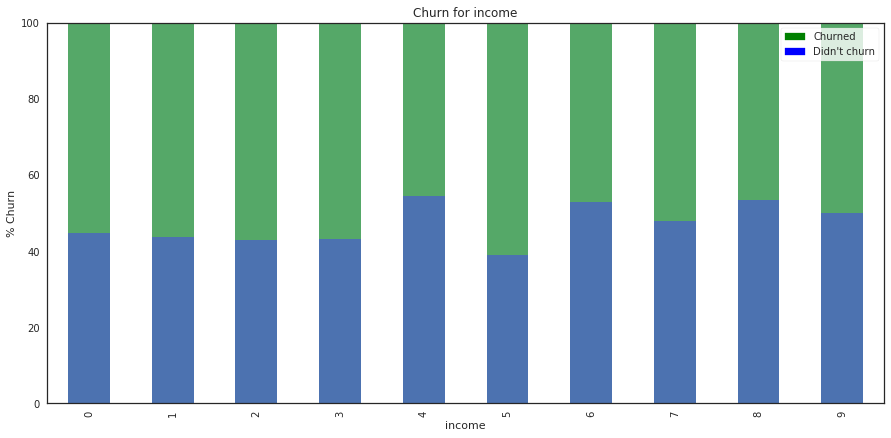

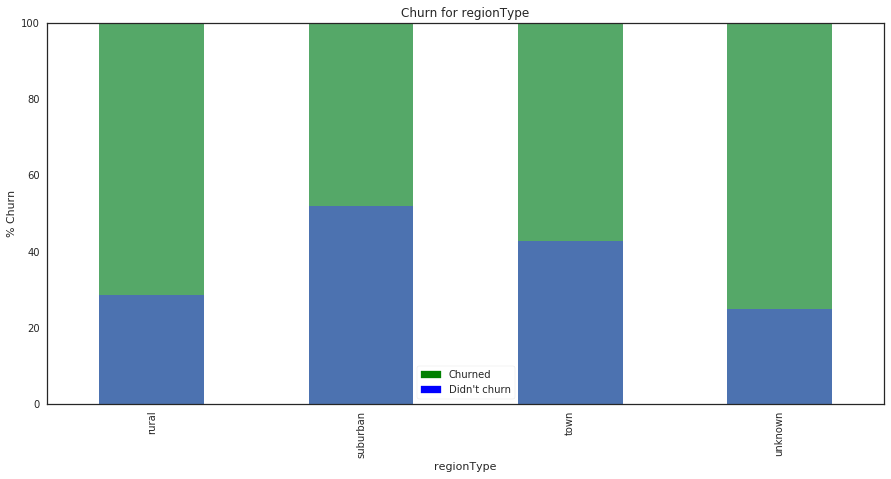

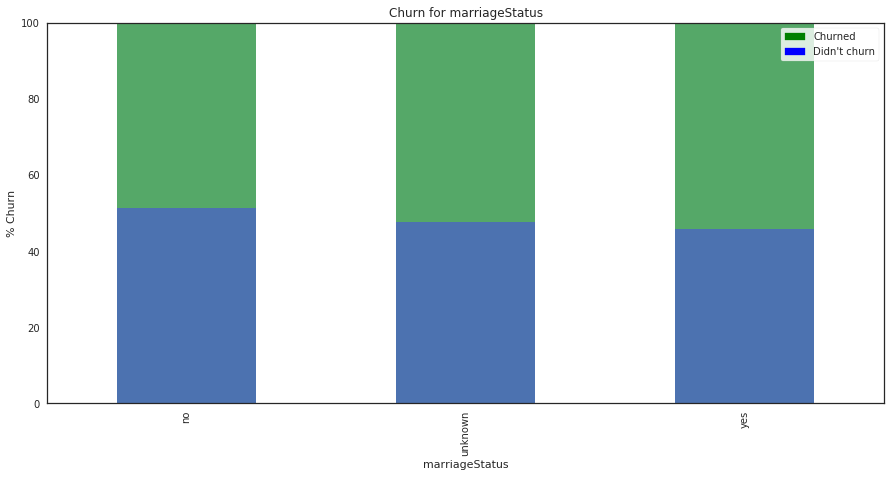

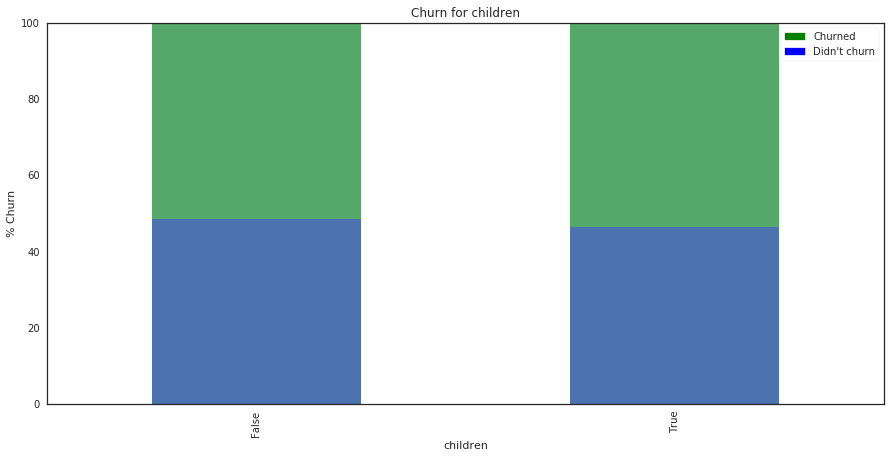

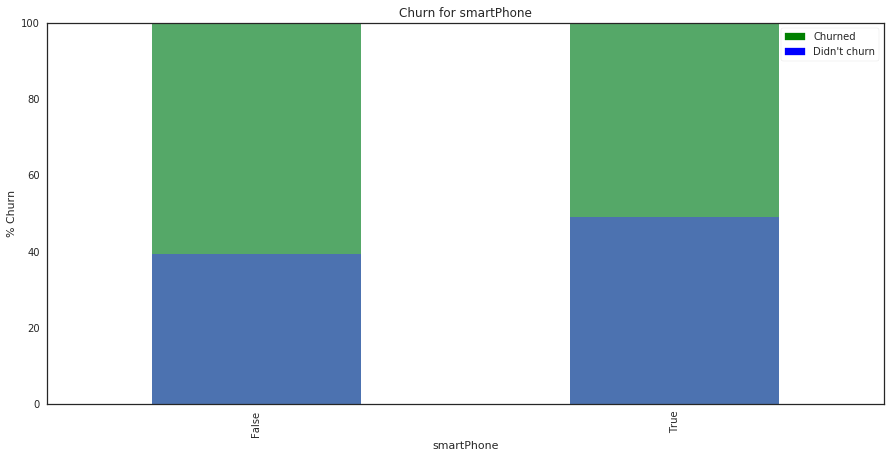

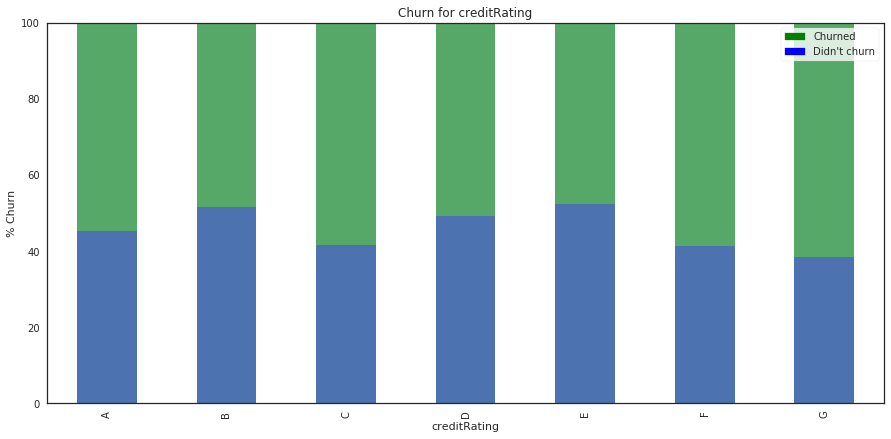

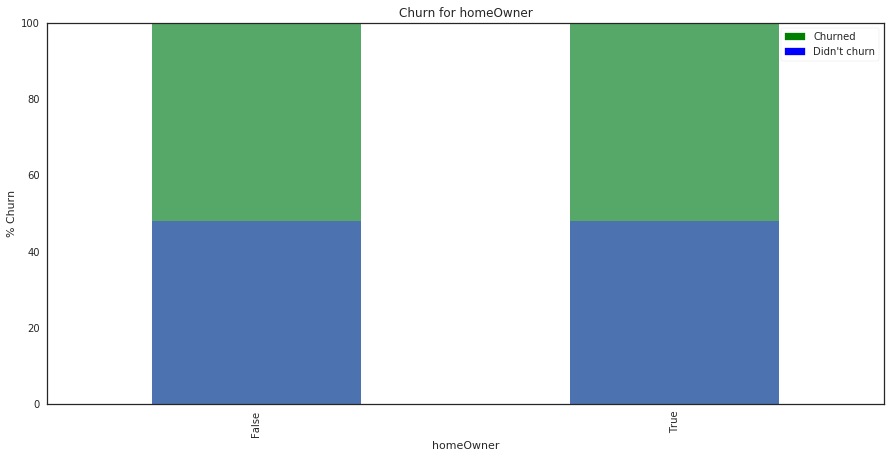

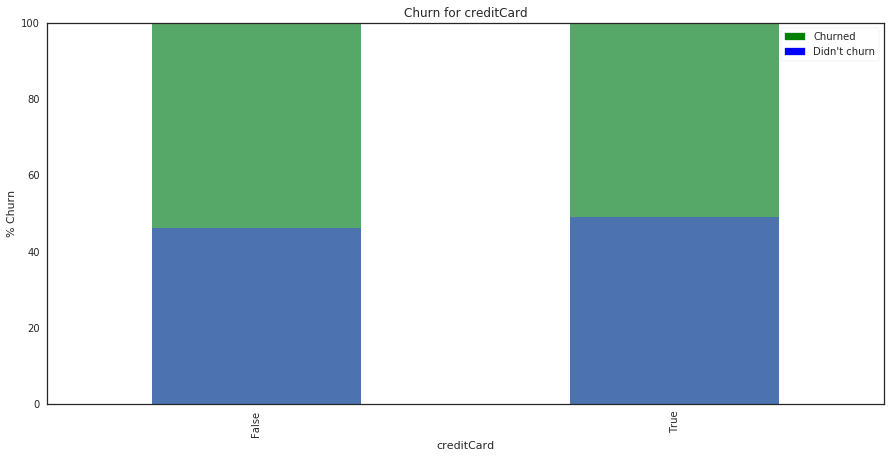

In [21]:
# Iterate through the unique values in each categorical feature and for each value count the amount of customers 
# who churned (excluding customer and the target feature churn)
chart_columns = categorical_columns.drop(['churn'],1)
pp = PdfPages('HW2_categorical_stackedBarCharts_17205389.pdf')
for i in chart_columns:

    feature = pd.unique(train_df[i].ravel())
    train_df['percent'] = 0

    # Find the indexes of each row, and for each of these row insert count * 100 in the percent column
    for p in feature:
        count = 1 / train_df[train_df[i] == p].count()['churn']
        index_list = train_df[train_df[i] == p].index.tolist()
        for j in index_list:
            train_df.loc[j, 'percent'] = count * 100

    # Group dataframe by categorical feature and Churn and sum percent
    group = train_df[['percent',i,'churn']].groupby([i,'churn']).sum()

    # Plot values of group in a stacked bar chart
    my_plot = group.unstack().plot(kind='bar', stacked=True, title= "Churn for " + i, figsize=(15,7))

    # Define label colours and text and add to the plot
    green_key = mpatches.Patch(color='green', label='Churned')
    blue_key = mpatches.Patch(color='blue', label='Didn\'t churn')
    my_plot.legend(handles=[green_key, blue_key], frameon = True)

    # Define x and y labels and min and max values for the y axis
    my_plot.set_xlabel(i)
    my_plot.set_ylabel("% Churn")
    my_plot.set_ylim([0,100])
    pp.savefig(f.get_figure())    
pp.close()

In [22]:
#df[categorical_columns].describe().T
train_df.groupby('churn')['income'].describe()

count  unique  top  freq
churn                          
0        336      10    0    78
1        364      10    0    96

In [23]:
train_df.groupby('income')['income'].apply(lambda x: x.count())

income
0    174
1     32
2      7
3     51
4     66
5     46
6    121
7     92
8     45
9     66
Name: income, dtype: int64

In [24]:
train_df.groupby('regionType')['regionType'].apply(lambda x: x.count())

regionType
rural        35
suburban    229
town         98
unknown       8
Name: regionType, dtype: int64

In [25]:
train_df.isnull().sum()['regionType']

330

In [26]:
train_df.groupby('creditCard')['creditCard'].apply(lambda x: x.count())

creditCard
False    232
True     468
Name: creditCard, dtype: int64

### (f) Discuss what knowledge you gain from these plots, e.g., which categorical features seem to be better at predicting the target feature? Choose a subset of categorical features you find promising. Justify your choices. 

From my observation of the stacked bar charts for each categorical feature, I selected three features which may hold value in predicitng the target feature, churn. I discuss the validity of each below.

    - income
From the graph, income looks like a strong predictor of churn. This would make sense regardless of the data as people with lower income are likely to look for cheaper phone plans to get the most out of their small income. Larger income earners are naturally less likely to do this. The smallest four categories of income(0-3) are around 55% churn, with the remaining, larger incomes at around 45% churn (with the exception of category 5 at roughly 60% churn). Overall I feel that income is a promising feature in terms of churn prediction.

    - regionType
With churn at roughly 70% for rural, 60% for town and 50% for suburban, a customer's regionType may be a promising feature in churn prediction. Such statistics make logical sense as churn can be affected by service, which can be heavily dictated by location. This data has many flaws however, including null values of almost 50%. Thus, it would not be prudent to use this feature as a churn predictor.

    - smartPhone
smartPhone also looks like a promising predictor of churn with roughly 60% and 50% of non-smartphone and smartphone owners, churning respectively. 90% of the customers are smartphone holders, however this is expected given the rise in the use of smartphones in recent years. The older technoloogies in non-smartPhones can thus often experience poor connection and general service, justifying the higher churn rate for these customers. Therefore, I feel smartPhone to be a promising feature in predicting churn

Therefore, the subset of categorical features I find promising are: 
    - income
    - smartPhone



# (2). Predictive Modeling: Linear Regression.

### (2.1) On the training set, train a linear regression model to predict the target feature Churn, using only the descriptive features selected in exercise (1) above. 

In [27]:
lm_train = sm.ols(formula="churn ~ avgOverBundleMins + handsetAge + income + smartPhone", data=train_df).fit()

### (2.2) Print the coefficients learned by the model 

In [28]:
# Print the model weights/parameters
print(lm_train.params)

Intercept             0.546627
income[T.1]           0.002195
income[T.2]           0.037703
income[T.3]           0.011988
income[T.4]          -0.115550
income[T.5]           0.046334
income[T.6]          -0.085221
income[T.7]          -0.039341
income[T.8]          -0.104362
income[T.9]          -0.059525
smartPhone[T.True]   -0.066726
avgOverBundleMins     0.000293
handsetAge            0.000151
dtype: float64


In [29]:
# Print the detailed metrics for the trained model.
print(lm_train.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.135
Date:                Sun, 08 Apr 2018   Prob (F-statistic):              0.328
Time:                        12:25:01   Log-Likelihood:                -500.62
No. Observations:                 700   AIC:                             1027.
Df Residuals:                     687   BIC:                             1086.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5466      0

### and discuss their role in the model (e.g., interpret the model) 
Linear regression takes features and creates a model that can be represented by a straight line, to predict churn.
The coefficients learned by the model represent a set of parameters/weights which contribute towards predicting churn, given values for each feature. 

As seen above, the coefficient for avgOverBundleMins = 0.0003. This means that the value of churn increases by 0.0003 units for every 1 minute increase in avgOverBundleMins. Similarly, the value of churn increases by 0.0002 units for every 1 year increase in handsetAge.

With coefficients of just over 0.1 Income[T.4] and Income[T.8] have the highest coefficients in the model, however both hold negative correlation with churn. 

Given a value for each feature, the sum of all features multiplied by their weight, plus the intercept, gives a predicted result for churn.

The intercept of 0.54 means that the line created by this model, crosses the vertical axis at 0.54. Thus if all values of the features were set to 0, the predicted churn value would be 0.54.

The R squared value is particularly poor at 0.019, the ideal result being 1 where all data points sit on the line of best fit of the model.

Model:
churn = 0.547 + income1 x 0.002 + income2 x 0.038 + income3 x 0.012 - income4 x 0.116 + income5 x 0.046 - income6 x 0.085 - income7 x 0.039 - income8 x 0.104 - income9 x 0.059 - smartPhone(true) x 0.0.067 + avgOverBundleMins x 0.000 + handsetAge x 0.000


### (2.3) Print the predicted target feature value for the first 100 training examples.

In [30]:
predict_df = lm_train.predict(train_df)
predict_df.head(100)

0     0.474157
1     0.405558
2     0.549431
3     0.465334
4     0.516552
5     0.602131
6     0.615975
7     0.451092
8     0.556608
9     0.491415
10    0.639706
11    0.595084
12    0.567092
13    0.551903
14    0.485404
15    0.431728
16    0.512624
17    0.628673
18    0.530850
19    0.505704
20    0.590153
21    0.425072
22    0.604432
23    0.536458
24    0.639043
25    0.549239
26    0.420093
27    0.497059
28    0.434556
29    0.493281
        ...   
70    0.524248
71    0.487344
72    0.411526
73    0.518104
74    0.466196
75    0.530572
76    0.444208
77    0.450090
78    0.419837
79    0.600947
80    0.430315
81    0.449370
82    0.422719
83    0.485170
84    0.469345
85    0.670111
86    0.542035
87    0.523671
88    0.447965
89    0.423860
90    0.578051
91    0.564891
92    0.504038
93    0.550953
94    0.506068
95    0.556542
96    0.492978
97    0.595870
98    0.454301
99    0.571965
Length: 100, dtype: float64

### Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example.

In [31]:
ChurnClass = (predict_df  > 0.5) * 1
df_ChurnClass = pd.DataFrame({'ChurnClass': ChurnClass})

###  Print the predicted class for the first 100 examples.

In [32]:
df_ChurnClass.head(100)

ChurnClass
0            0
1            0
2            1
3            0
4            1
5            1
6            1
7            0
8            1
9            0
10           1
11           1
12           1
13           1
14           0
15           0
16           1
17           1
18           1
19           1
20           1
21           0
22           1
23           1
24           1
25           1
26           0
27           0
28           0
29           0
..         ...
70           1
71           0
72           0
73           1
74           0
75           1
76           0
77           0
78           0
79           1
80           0
81           0
82           0
83           0
84           0
85           1
86           1
87           1
88           0
89           0
90           1
91           1
92           1
93           1
94           1
95           1
96           0
97           1
98           0
99           1

[100 rows x 1 columns]

### Print the classification evaluation measures computed on the training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) 

In [33]:
train_y = train_df.churn
train_predictions = df_ChurnClass

In [34]:
# Some more evaluation metrics.
print("Accuracy: ", metrics.accuracy_score(train_y, train_predictions))
print("Confusion matrix:\n ", metrics.confusion_matrix(train_y, train_predictions))
print("Classification report:\n ", metrics.classification_report(train_y, train_predictions))
# Print the Mean Absolute Error of the model on the training set
mae = abs(train_y - predict_df).mean()
print("\nMean Absolute Error:\n", mae)
# Print the Mean Squared Error of the model on the training set
mse = ((train_y - predict_df)** 2).mean()
print("\nMean Squared Error:\n", mse)

Accuracy:  0.554285714286
Confusion matrix:
  [[148 188]
 [124 240]]
Classification report:
               precision    recall  f1-score   support

          0       0.54      0.44      0.49       336
          1       0.56      0.66      0.61       364

avg / total       0.55      0.55      0.55       700


Mean Absolute Error:
 0.48949492857282006

Mean Squared Error:
 0.2447474642864073


### ...and discuss your findings so far. 
#### Training dataset:
|| Predicted: no churn | Predicted: churn |
|-|-|-|
|Actual: no churn | 148 | 188 | *336* |
|Actual: churn | 124 | 240 | *364*|
||*272*|*428*|**700**|

    - True positive rate = 240/364 = 0.66
    - False positive rate = 124/272 = 0.46
    - Error rate = 188+124 / 700 = 0.45

With an Accuracy rate of 0.55, the model does a modest job at predicting churn. This means that the model correctly predicted the result of churn, for 55% of the 700 training set customers. The model therefore incorrectly predicted churn 45% of the time.

The recall score of 0.66 for churn shows that of the 700 customers that did churn, the model predicted 66% of these cases. However with a recall of 44% for the no churn case, overall recall is 55%. 

The f1-score, a weighted average of recall and precision, is at 0.55. The f1 can be more useful than accuracy, "especially if you have an uneven class distribution"(ref1). However, both accuracy and f1-score are the same here, thus hold the same value.
The MAE figure of 0.489 and MSE figure of 0.245 show different measures of average distances of data points from the line of best fit.

So far, I feel the model does a modest job at predicting churn. Ideally the accuracy and f1-scores of 0.55 would be higher, therefore research should be carried out into other features that may yield a higher f1-score. 




(ref1) http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

### (2.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set.

In [35]:
test_df = pd.read_csv('test_CustomerChurn-17205389.csv', sep=',')

# Select columns containing categorical data
categorical_columns = test_df[['income', 'regionType','marriageStatus','children','smartPhone',
                          'creditRating','homeOwner','creditCard']].columns

# Convert data type to category for these columns
for column in categorical_columns:
    test_df[column] = test_df[column].astype('category')

In [36]:
test_df['churn'] = test_df['churn'].astype('int64')
test_predict_df = lm_train.predict(test_df)

In [37]:
TestChurnClass = (test_predict_df  > 0.5) * 1
df_TestChurnClass = pd.DataFrame({'TestChurnClass': TestChurnClass})

In [38]:
y_test = test_df.churn
predictions_test = df_TestChurnClass

In [39]:
print("Accuracy: ", metrics.accuracy_score(y_test, predictions_test))
print("Confusion matrix:\n ", metrics.confusion_matrix(y_test, predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, predictions_test))
# Print the Mean Absolute Error of the model on the training set
mae = abs(y_test - test_predict_df).mean()
print("\nMean Absolute Error:\n", mae)
# Print the Mean Squared Error of the model on the training set
mse = ((y_test - test_predict_df)** 2).mean()
print("\nMean Squared Error:\n", mse)

Accuracy:  0.566666666667
Confusion matrix:
  [[ 64  78]
 [ 52 106]]
Classification report:
               precision    recall  f1-score   support

          0       0.55      0.45      0.50       142
          1       0.58      0.67      0.62       158

avg / total       0.56      0.57      0.56       300


Mean Absolute Error:
 0.48778974312793394

Mean Squared Error:
 0.24281639997321472


### Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation.
#### Test dataset:
|| Predicted: no churn | Predicted: churn |
|-|-|-|
|Actual: no churn | 64 | 78 | *142* |
|Actual: churn | 52 | 106 | *158*|
||*116*|*184*|**300**|

    -True positive rate = 106/158 = 0.67
    -False positive rate = 52/116 = 0.45
    -Error rate = 78+52 / 300 = 0.43
    
    
Both the test and training datasets show very similar results for these classification evaluation measures. The test data yields slightly more favourable results with a higher accuracy (57%), recall(57%) and f1-score(56%). It therefore has a greater true positive rate and a lower false positive rate. 

This model does a reasonably good job at predicting churn at a 0.56 accuracy rate (average across the test and train). Again, if other features were tested and possibly if features were dropped from the model, a higher accuracy rate could be experienced. 



### Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [40]:
full_df = pd.read_csv('shuffled_CustomerChurn-17205389.csv', sep=',')
full_df['churn'] = full_df['churn'].astype('int64')

In [41]:
#Split the dataset into 5 datasets for a 5-fold cross-validation
split_full_df = np.split(full_df, 5, axis=0)
crossval_test1 = split_full_df[0]
crossval_test2 = split_full_df[1]
crossval_test3 = split_full_df[2]
crossval_test4 = split_full_df[3]
crossval_test5 = split_full_df[4]
crossval_train1 = pd.concat([split_full_df[1],split_full_df[2],split_full_df[3],split_full_df[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
crossval_train2 = pd.concat([split_full_df[0],split_full_df[2],split_full_df[3],split_full_df[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
crossval_train3 = pd.concat([split_full_df[1],split_full_df[0],split_full_df[3],split_full_df[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
crossval_train4 = pd.concat([split_full_df[1],split_full_df[2],split_full_df[0],split_full_df[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
crossval_train5 = pd.concat([split_full_df[1],split_full_df[2],split_full_df[3],split_full_df[0]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)

In [42]:
crossval_train_list = [crossval_train1, crossval_train2, crossval_train3, crossval_train4, crossval_train5]
crossval_test_list = [crossval_test1, crossval_test2, crossval_test3, crossval_test4, crossval_test5]

for i in range (0,5):
    crossval_train = crossval_train_list[i]
    crossval_test = crossval_test_list[i]
    crossval_lm = sm.ols(formula="churn ~ avgOverBundleMins + handsetAge + income + smartPhone", data=crossval_train).fit()
    test_predict = crossval_lm.predict(crossval_test)
    test_predict_class = (test_predict>0.5) *1.0
    df_test_predict_class = pd.DataFrame({'test_predict_class': test_predict_class})
    y = crossval_test['churn']
    print("Test", i+1, "Classification Measurements\n")
    print("Accuracy: ", metrics.accuracy_score(y,df_test_predict_class))
    print("Confusion matrix: \n", metrics.confusion_matrix(y, df_test_predict_class))
    print("Classification report:\n ", metrics.classification_report(y, df_test_predict_class))
    mse = ((crossval_test.churn - test_predict)** 2).mean()
    print("\nMean Squared Error:\n", mse)
    mae = abs(crossval_test.churn - test_predict).mean()
    print("\nMean Absolute Error:\n", mae, "\n")

Test 1 Classification Measurements

Accuracy:  0.495
Confusion matrix: 
 [[42 55]
 [46 57]]
Classification report:
               precision    recall  f1-score   support

          0       0.48      0.43      0.45        97
          1       0.51      0.55      0.53       103

avg / total       0.49      0.49      0.49       200


Mean Squared Error:
 0.2525205958261154

Mean Absolute Error:
 0.4979128637715016 

Test 2 Classification Measurements

Accuracy:  0.55
Confusion matrix: 
 [[49 46]
 [44 61]]
Classification report:
               precision    recall  f1-score   support

          0       0.53      0.52      0.52        95
          1       0.57      0.58      0.58       105

avg / total       0.55      0.55      0.55       200


Mean Squared Error:
 0.24756508000450006

Mean Absolute Error:
 0.49289500829139304 

Test 3 Classification Measurements

Accuracy:  0.565
Confusion matrix: 
 [[44 61]
 [26 69]]
Classification report:
               precision    recall  f1-score   sup

### Comparison:   
#### Cross-Validation:
From the 5 fold cross-validation, I took an average of the predicted and actual figures for churn, giving the following summary:

|| Predicted: no churn | Predicted: churn |
|-|-|-|
|Actual: no churn | 44 | 52 | *96* |
|Actual: churn | 42 | 62 | *104*|
||*86*|*114*|**200**|

    - True positive rate = 62/104 = 0.60
    - False positive rate = 42/86 = 0.45
    - Error rate = 52+42 / 200 = 0.47

The average classification metrics across the 5 folds: 
    - accuracy, precision, recall, f1-score = 0.53 
    - MSE = 0.2484
    - MAE = 0.4936
 
The average accross the 5-fold cross-validation, yields an accuracy of 0.53. This figure is lower then both the training and test datasets with accuracies of 0.55 and 0.57 respectively, as seen above. 

The average MSE and MAE figures across the 5-fold CV, are both slightly higher then the corresponding figures for the test and training evaluations above. This shows a greater spread of data from the line of best fit, compared to to test and train data.

The slightly less promising figures may show a more accurate picture of the dataset, and the model that has been created. Cross-validation combats against results that are one-time lucky, by testing across the whole dataset. Thus, it is posisble that the slightly more favourable results in the test and train, are not completely representative. However, the CV results are not that different to the test and train, thus does not raise a major concern.
   


# (3). Predictive Modeling: Logistic Regression.

### (3.1) On the training set, train a logistic regression model to predict the target feature Churn, using the descriptive features selected in exercise (1) above.   

In [43]:
intercept = pd.DataFrame({'Intercept': np.ones(700)})

train_X = pd.concat([intercept, train_df[['avgOverBundleMins', 'handsetAge', 'income', 'smartPhone']]], axis=1)
train_y = train_df.churn

logreg = LogisticRegression().fit(train_X, train_y)


### (3.2) Print the coefficients learned by the model and 

In [44]:
# Examine the estimated logistic regression coefficients.
print("Coeficients: \n", logreg.coef_)

Coeficients: 
 [[ 0.05825227  0.00116008  0.00065007 -0.03576087 -0.20647646]]


### ...discuss their role in the model (e.g., interpret the model).   
In logistic regression, the coefficients represent the change in the log-odds for a unit change in the feature corresponding to that coefficient. The log-odds in this case refers to the logarithm of the odds, where odds is the ratio of the probability of the event, by its compliment.

For example, in this logistic regression, the coefficient for avgOverBundleMins is 0.0012. Therefore a 1 minute increase in avgOverBundleMins will result in a 0.0012 unit increase in the log-odds. This means that e to the power of 0.0012 gives us the change in the odds, for a 1 min increase in avgOverBundleMins. Similarly, e to the power of 0.00065 gives us the change in the odds, for a 1 year increase in handsetAge.

The intercept of 0.0582 represents the log-odds when the value of all the features are equal to zero. So if the value of avgOverBundleMins, handsetAge, income and smartPhone were zero, the log-odds would be 0.0582.

### (3.3) Print the predicted target feature value for the first 100 training examples.

In [45]:
logreg.predict_proba(train_X[:100])

array([[ 0.54513768,  0.45486232],
       [ 0.51404515,  0.48595485],
       [ 0.45176232,  0.54823768],
       [ 0.49816161,  0.50183839],
       [ 0.50941777,  0.49058223],
       [ 0.40946167,  0.59053833],
       [ 0.39943871,  0.60056129],
       [ 0.51472987,  0.48527013],
       [ 0.48332657,  0.51667343],
       [ 0.51014019,  0.48985981],
       [ 0.44568298,  0.55431702],
       [ 0.40621642,  0.59378358],
       [ 0.36428659,  0.63571341],
       [ 0.44756157,  0.55243843],
       [ 0.53690183,  0.46309817],
       [ 0.53446115,  0.46553885],
       [ 0.48739168,  0.51260832],
       [ 0.38302973,  0.61697027],
       [ 0.50911637,  0.49088363],
       [ 0.51518691,  0.48481309],
       [ 0.34178541,  0.65821459],
       [ 0.59668404,  0.40331596],
       [ 0.39069575,  0.60930425],
       [ 0.48220787,  0.51779213],
       [ 0.36482756,  0.63517244],
       [ 0.54283627,  0.45716373],
       [ 0.54917451,  0.45082549],
       [ 0.52447059,  0.47552941],
       [ 0.53579962,

### Print the predicted class for the first 100 examples.

In [46]:
log_train_predictions = logreg.predict(train_X)
hundred_predictions = log_train_predictions[:100]
print("Predictions: ", hundred_predictions)

Predictions:  [0 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1
 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1]


### Print the classification evaluation measures computed on the training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1)

In [47]:
print("Accuracy: ", metrics.accuracy_score(train_y, log_train_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(train_y, log_train_predictions))
print("Classification report:\n ", metrics.classification_report(train_y, log_train_predictions))


Accuracy:  0.524285714286
Confusion matrix: 
 [[139 197]
 [136 228]]
Classification report:
               precision    recall  f1-score   support

          0       0.51      0.41      0.45       336
          1       0.54      0.63      0.58       364

avg / total       0.52      0.52      0.52       700



### ...and discuss your findings so far.
#### Training dataset:
|| Predicted: no churn | Predicted: churn |
|-|-|-|
|Actual: no churn | 139 | 197 | *336* |
|Actual: churn | 136 | 228 | *364*|
||*275*|*425*|**700**|

    - True positive rate = 228/364 = 0.63
    - False positive rate = 136/275 = 0.49
    - Error rate = 197+136 / 700 = 0.48

With an Accuracy rate of 0.52, the model does a slightly worse job at predicting churn, versus the linear regression model with an accuracy of 0.55 on the same data set. Thus, the error rate is also higher at 48% vs 45% from the linear regression.

The recall score of 0.63 for churn shows that of the 700 customers that did churn, the model predicted 63% of these cases. Again, overall recall of 52% is less than that of the linear regression at 55%. 

As per the linear regression, the acuracy, precision, recall and f1-score all have the same value. Thus, this model is slighlty less accurate than that of the linear on all these measures.

This model does an average job at predicting churn, at a slightly worse rate than its linear equivalent. Ideally the accuracy and f1-scores of 0.52 would be higher, therefore research should be carried out into other features that may yield a higher f1-score. 


### (3.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set.

In [48]:
intercept = pd.DataFrame({'Intercept': np.ones(300)})

test_X = pd.concat([intercept, test_df[['avgOverBundleMins', 'handsetAge', 'income', 'smartPhone']]], axis=1)
test_y = test_df.churn

logreg = LogisticRegression().fit(test_X, test_y)

# Examine the estimated logistic regression coefficients.
print("Coeficients: \n", logreg.coef_)

test_predictions = logreg.predict(test_X)
print("Predictions (class): \n", test_predictions)

Coeficients: 
 [[ 0.05214038  0.00370056  0.00063429 -0.01807031 -0.34363103]]
Predictions (class): 
 [0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0
 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0
 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0
 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0 1
 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0
 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0
 0 0 1 1]


In [49]:
print("Accuracy: ", metrics.accuracy_score(test_y, test_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(test_y, test_predictions))
print("Classification report:\n ", metrics.classification_report(test_y, test_predictions))

Accuracy:  0.583333333333
Confusion matrix: 
 [[ 75  67]
 [ 58 100]]
Classification report:
               precision    recall  f1-score   support

          0       0.56      0.53      0.55       142
          1       0.60      0.63      0.62       158

avg / total       0.58      0.58      0.58       300



### Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation.

#### Test dataset:
|| Predicted: no churn | Predicted: churn |
|-|-|-|
|Actual: no churn | 75 | 67 | *142* |
|Actual: churn | 58 | 100 | *158*|
||*133*|*167*|**300**|

    -True positive rate = 100/158 = 0.63
    -False positive rate = 58/133 = 0.44
    -Error rate = 67+58 / 300 = 0.42
    
    
The classification evaluation measures shows more favourable results from the test dataset of this logistic regression, versus the training data. The test data yields more favourable results with a higher accuracy, recall and f1-score, all of 58%. The test data also has the same true positive rate, however a lower false positive rate and error rate. 

In comparison with the linear regression of the same test data set, the logistic regression results in a slightly higher accuracy versus the linear equivalent of 0.57.

This model does a good job at predicting churn at a 0.55 accuracy rate (average across the test and train). Compared to the average of the test and train accuracy from the linear regression (0.56) there is very little difference in using either model.


### Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [50]:
#read in the full dataset again
crossval_df = pd.read_csv('shuffled_CustomerChurn-17205389.csv', sep=',')
#Select columns containing categorical data
categorical_columns = crossval_df[['income', 'regionType','marriageStatus','children','smartPhone',
                         'creditRating','homeOwner','creditCard']].columns

# Convert data type to category for these columns
for column in categorical_columns:
    crossval_df[column] = crossval_df[column].astype('category')

crossval_df['churn'] = crossval_df['churn'].astype('int64')

In [51]:
crossval_intercept = pd.DataFrame({'Intercept': np.ones(1000)})
crossval_X = pd.concat([crossval_intercept, crossval_df[['avgOverBundleMins', 'handsetAge', 'income', 'smartPhone']]], axis=1)
crossval_y = crossval_df.churn

In [52]:
precision_scores = cross_val_score(LogisticRegression(), crossval_X, crossval_y, scoring='precision', cv=5)
print(precision_scores)
print(precision_scores.mean())

[ 0.52631579  0.57407407  0.54285714  0.54761905  0.54471545]
0.547116300236


In [53]:
precision_recall = cross_val_score(LogisticRegression(), crossval_X, crossval_y, scoring='recall', cv=5)
print(precision_recall)
print(precision_recall.mean())

[ 0.57142857  0.59047619  0.54807692  0.66346154  0.64423077]
0.603534798535


In [54]:
f1_scores = cross_val_score(LogisticRegression(), crossval_X, crossval_y, scoring='f1', cv=5)
print(f1_scores)
print(f1_scores.mean())

[ 0.54794521  0.58215962  0.54545455  0.6         0.59030837]
0.573173549078


In [55]:
accuracy_scores = cross_val_score(LogisticRegression(), crossval_X, crossval_y, scoring='accuracy', cv=5)
print(accuracy_scores)
print(accuracy_scores.mean())

[ 0.50746269  0.55721393  0.525       0.53768844  0.53266332]
0.532005675142


### Comparison:
|| **Train**| **Test** | **Cross-Validation** |
|-|-|-|-|
|Accuracy| 0.52 | 0.58 | 0.53|
|Precision| 0.52 | 0.58 | 0.55|
|Recall|0.52|0.58|0.60|
|f1-score|0.52|0.58|0.57|

Unlike the Train and Test measures, the classification measures on the cross-validated model are more varied. The average accuracy, precision and f1-score across the 5-fold CV are all less than the test data but greater than the train data. While the recall of the CV model of 0.60 is greater than both the train and test equivalents

# (4). Improving Predictive Models.

### (4.1) Which model of the ones trained above performs better at predicting Churn? Is it more accurate than a simple (but useless) model that always predicts the majority class (i.e., if Churn=0 is the majority class in your dataset, the simple model always predicts 0 for the target feature)? Justify your answers.

In [56]:
#count 1 and 0 values for churn on the whole dataset
full_df.groupby('churn')['churn'].apply(lambda x: x.count())

churn
0    478
1    522
Name: churn, dtype: int64

In [57]:
full_predict_df = lm_train.predict(full_df)
FullChurnClass = (full_predict_df  > 0.5) * 1
df_FullChurnClass = pd.DataFrame({'FullChurnClass': FullChurnClass})
y_full = full_df.churn
print("Accuracy: ", metrics.accuracy_score(y_full, df_FullChurnClass))

Accuracy:  0.558


In order to compare the models I have trained thus far, I will look at the accuracy yielded from the linear and logistic models on the test and training data as well as the cross-validated models.

|| **Accuracy**|
|-|-|-|-|
|Linear(train) | 0.55 |
|Linear(test) | 0.57|
|Liner - CV| 0.53 |
|Logistic(train)|0.52|
|Logistic(test) |0.58|
|Logistic - CV|0.53 |

A simple model that always predicts the majority class, will predict churn = 1 for each customer, as churn is the majority with a count of 522 customers out of 1000. This model will therefore correctly predict 52.2% of churn. From the above accuracies, I would choose the linear model which resulted in a 0.55, 0.57 and 0.53 accuracy from the train, test and CV data respectively. The results are more consistent than those evident in the logistic equivalent. 

As seen above, using the linear model created on the training set (lm_train), on the full dataset, results in an accuracy of 0.56. It is therefore more accurate than the simple but useless model that has an accuracy of 0.52.

###  (4.2) Summarise your understanding of the problem and of your predictive modeling results so far. 
The problem that we have been presented with is that this company has experienced too many customers churning, likley for several reasons. These reasons could be related to cheaper plans in other mobile providers, customers experiencing lower incomes, poor service in their area or many other reasons. Our goal has been to create a model that may shed light on some of these reasons. Figuring out the exact motivations for customer churn, would therefore result in a greater ability to predict and prevent it.

Thus far, the models that have been created have experienced accuracy levels of between 0.52 and 0.58. These models have looked at avgOverBundleMins, handsetAge, income and smartPhone in trying to explain churn. In order to yield higher accuracy levels to further enhance our ability to predict churn, some adjustments to the dataset and the should be carried out.

### Can you think of any new ideas to improve the best model so far (e.g., by using furher data prep such as: feature selection, feature re-scaling, creating new features, combining models, or using other knowledge)? 

In order to try and improve the best model I have created so far, I need to analyse the dataset and see if changes need to be made in order to have more meaningful solutions. I will investigate whether or not I could have dropped or adjusted certian features on initial inspection of the data.

In [58]:
# Check whether there are null values in the data where values would be expected
full_df.isnull().sum()

customer                        0
age                           284
regionType                    472
marriageStatus                  0
children                        0
income                          0
numHandsets                     0
handsetAge                      0
smartPhone                      0
currentHandsetPrice             0
creditRating                    0
homeOwner                       0
creditCard                      0
avgBill                         0
avgMins                         0
avgrecurringCharge              0
avgOverBundleMins               0
avgRoamCalls                    0
callMinutesChangePct            0
billAmountChangePct             0
avgReceivedMins                 0
avgOutCalls                     0
avgInCalls                      0
peakOffPeakRatio                0
peakOffPeakRatioChangePct       0
avgDroppedCalls                 0
lifeTime                        0
lastMonthCustomerCareCalls      0
numRetentionCalls               0
numRetentionOf

## age
Age has almost 30% zero values. Previoulsy I set these zero values to NaN as I believed these values represented under 18 year old whos data could not be collected. Further investigation is needed.

In [59]:
full_df['age']=full_df['age'].replace(np.nan, 0)
# replace the nan values back to zero to analyse the feature
temp_df = full_df[full_df['age'] == 0]
temp_df = temp_df[temp_df['children'] == True]
temp_df[['age', 'children']]

age  children
34   0.0      True
223  0.0      True
259  0.0      True
367  0.0      True
401  0.0      True
630  0.0      True
952  0.0      True

In [60]:
temp_df = temp_df[temp_df['homeOwner'] == True]
temp_df.head(5)[['age', 'homeOwner']]

age  homeOwner
34   0.0       True
223  0.0       True
367  0.0       True
401  0.0       True
630  0.0       True

Of the 284 customers, with an age of 0, there is evidence that some of these customers have children and own a house. Both these attributes are unlikely at the age of 18 or below. Thuse it is possible that these zero values are mistakes in the data and these people are actually over the age of 18. Due to this uncertainty, I will preform imputation and replace the zero values with the median age of the dataset.

In [61]:
print(full_df['age'].median())
full_df['age'] = full_df['age'].replace(0, full_df['age'].median())

34.0


## currentHandsetPrice

In my Data Quality Report and Plan (Homework1), I justified the high levels of zero values in the currentHandsetPrice feature. I argued that thes values may be due to free phones being given out as part of sign on promotions or plans that give a free phone, in return for a monthly bill . Further investigation shuld be carried out to justify this reasoning

In [62]:
full_df[full_df['currentHandsetPrice'] == 0]['currentHandsetPrice'].count()

552

In [63]:
full_df[full_df['currentHandsetPrice'] == 0][full_df['avgMins'] == 0][['currentHandsetPrice', 'avgBill', 'avgMins']]

/home/obyrned1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


currentHandsetPrice  avgBill  avgMins
69                   0.0     4.84      0.0
82                   0.0    59.99      0.0
123                  0.0   163.23      0.0
129                  0.0     0.00      0.0
191                  0.0    19.99      0.0
339                  0.0    26.45      0.0
364                  0.0    22.49      0.0
377                  0.0     3.03      0.0
409                  0.0     5.05      0.0
420                  0.0    10.00      0.0
496                  0.0    19.99      0.0
537                  0.0    32.49      0.0
550                  0.0     0.00      0.0
580                  0.0    23.07      0.0

Where phones had the price of 0, I investigated whether these customers experienced a consistent average bill. If these customers did have similar avgBills it would support the arguement that these phones are given free in return for monthly payments, expected to be about 50 euro a month for two years for example. The results however are far from convincing with avgBills rangings from 3.03-163.23 euro (not including the 0 avgBill). Thus, I conclude that the zero value given for currenHandsetPrice is not justified by free phones, rather is a default value for missing data. 

With over 50% missing values, I have chosen to remove this feature.

In [64]:
full_df = full_df.drop('currentHandsetPrice', 1)

# regionType
Although with almost 50% missing values, I kept regionType in my dataset as I thought it would have explanatory value in our quest to predict churn. My reasoning being that certain region types experience varying levels of signal, which may affect churn.

In [65]:
full_df.groupby('regionType')['regionType'].apply(lambda x: x.count())

regionType
rural        53
suburban    313
town        153
unknown       9
Name: regionType, dtype: int64

However, given my current role in trying to make the datset more meaningful in order to more accurately predict churn, this feature must be dropped. With null values at 47% (48% including the 9 unknown), plus the minimal value shown by the feature in the stacked barcharts in Q1, dropping the feature is justified.

In [66]:
full_df = full_df.drop('regionType', 1)

# marriageStatus
In my Data Quality Plan (Homework 1), I justified the 40% unkown values in marriageStatus, by arguing that customers may want this information to be private. I hindsight, this was a naive reasoning, and the more likely reason behind the unkown value is due to missing values. This high level of missing values, coupled with the features lack of value in predicting churn, seen in the stacked bar charts in Q1, I have decided to drop the feature.

In [67]:
full_df = full_df.drop('marriageStatus', 1)

# Customer
I will also drop customer as it has no impact on our mission of predicting churn, rather is an indentification columns

In [68]:
full_df = full_df.drop('customer', 1)


# Normalising
In order to yield further improvements in the learning models, I will normalise all continuous features. This normalisation will combat the possibility of our models finding it diffuclt to interpret very different ranges within features. 

For the categorical columns,income and creditRating, I will create different columns for each of the category within the features. Each column will then contain a 1 or 0 value if the customer falls within this category. For the remaining categorical columns, I will also convert the true/false answers to 1/0 outcomes.


In [69]:
# Create columns for each value of credit rating, to be populated by 1's and 0's as appropriate
CR_A = (full_df.creditRating=='A') * 1.0
CR_B = (full_df.creditRating=='B') * 1.0
CR_C = (full_df.creditRating=='C') * 1.0
CR_D = (full_df.creditRating=='D') * 1.0
CR_E = (full_df.creditRating=='E') * 1.0
CR_F = (full_df.creditRating=='F') * 1.0
CR_G = (full_df.creditRating=='G') * 1.0
df_CreditRating = pd.DataFrame({'CR_A': CR_A,'CR_B': CR_B,'CR_C': CR_C,'CR_D': CR_D,'CR_E': CR_E,'CR_F': CR_F,'CR_G': CR_G})
df_new1 = pd.concat([full_df, df_CreditRating], axis = 1)
# no longer need the creditRating column
# df_new1 = df_new1.drop('creditRating', 1)

In [70]:
# I will do the same for the categories of Income
Inc_0 = (full_df.income==0) * 1.0
Inc_1 = (full_df.income==1) * 1.0
Inc_2 = (full_df.income==2) * 1.0
Inc_3 = (full_df.income==3) * 1.0
Inc_4 = (full_df.income==4) * 1.0
Inc_5 = (full_df.income==5) * 1.0
Inc_6 = (full_df.income==6) * 1.0
Inc_7 = (full_df.income==7) * 1.0
Inc_8 = (full_df.income==8) * 1.0
Inc_9 = (full_df.income==9) * 1.0
df_Income = pd.DataFrame({'Inc_0': Inc_0,'Inc_1': Inc_1,'Inc_2': Inc_2,'Inc_3': Inc_3,'Inc_4': Inc_4,'Inc_5': Inc_5,'Inc_6': Inc_6,'Inc_7': Inc_7,'Inc_8': Inc_8,'Inc_9': Inc_9,})
df_new2 = pd.concat([df_new1, df_Income], axis = 1)
# no longer need the Income column
# df_new2 = df_new2.drop('income', 1)

In [71]:
# I will then convert all other categorical columns to 1's and 0's rather than true or false
remaining_categorical_columns = df_new2[['children','smartPhone','homeOwner','creditCard', 'churn']].columns

# set their types to integers
for c in remaining_categorical_columns:
    df_new2[c] = df_new2[c].astype('int64')

# replace true/false with 1/0
for c in remaining_categorical_columns:
    df_new2[c].replace([True], 1 )
    df_new2[c].replace([False], 0 )

In [72]:
# I will then normalise the continuous columns to range between 1 and 0
cont_columns = df_new2[['age','numHandsets','handsetAge','avgBill','avgMins',
                         'avgrecurringCharge','avgOverBundleMins','avgRoamCalls','callMinutesChangePct',
                         'billAmountChangePct','avgReceivedMins','avgOutCalls','avgInCalls','peakOffPeakRatio',
                         'peakOffPeakRatioChangePct','avgDroppedCalls','lifeTime','lastMonthCustomerCareCalls',
                         'numRetentionCalls','numRetentionOffersAccepted','newFrequentNumbers']].columns
df_cont = df_new2[cont_columns]
df_norm = (df_cont - df_cont.min()) / (df_cont.max() - df_cont.min())


In [73]:
# I will then concatenate these normalised columns with the remaining columns
all_other_cols = df_new2 [['children','smartPhone','homeOwner','creditCard', 'CR_A','CR_B','CR_C','CR_D',
                            'CR_E','CR_F','CR_G', 'Inc_0','Inc_1','Inc_2','Inc_3','Inc_4','Inc_5',
                            'Inc_6','Inc_7','Inc_8','Inc_9', 'churn']]

df_new3 = pd.concat([df_norm, all_other_cols], axis = 1)

In [74]:
df_new3.to_csv('postFeatureAdjustments_CustomerChurn-17205389.csv', sep=',', index=False)
#save the full df to a csv

### Please show how your ideas actually work in practice, by training and evaluating your proposed models. 

In [75]:
improve_df = pd.read_csv('postFeatureAdjustments_CustomerChurn-17205389.csv', sep=',')

As I did in question 1, the following cell is commented out as I did not want different train and test sets to be created, each time the notebook is run

In [76]:
#splitting the df into train and test
#train1, test1 = train_test_split(improve_df, test_size=0.3)
#train1.to_csv('improve_training_CustomerChurn-17205389.csv', sep=',', index=False)
# save the train df to a csv
#test1.to_csv('improve_test_CustomerChurn-17205389.csv', sep=',', index=False)
# save the test df to a csv

### Create a model on the 70% training set

In [77]:
train1_df = pd.read_csv('improve_training_CustomerChurn-17205389.csv', sep=',')

In [78]:
lm_train1 = sm.ols(formula="churn ~ avgOverBundleMins + handsetAge + smartPhone + Inc_0 + Inc_1 + Inc_2 + Inc_3 + Inc_4 + Inc_5 + Inc_6 + Inc_7 + Inc_8 + Inc_9", data=train1_df).fit()

In [79]:
train1_predict_df = lm_train1.predict(train1_df)
train1_ChurnClass = (train1_predict_df  > 0.5) * 1
df_train1_ChurnClass = pd.DataFrame({'ChurnClass': train1_ChurnClass})
train1_y = train1_df.churn
train1_predictions = df_train1_ChurnClass

In [80]:
# evaluation metrics.
print("Accuracy: ", metrics.accuracy_score(train1_y, train1_predictions))
print("Confusion matrix:\n ", metrics.confusion_matrix(train1_y, train1_predictions))
print("Classification report:\n ", metrics.classification_report(train1_y, train1_predictions))
# Print the Mean Absolute Error of the model on the training set
mae = abs(train1_y - train1_predict_df).mean()
print("\nMean Absolute Error:\n", mae)
# Print the Mean Squared Error of the model on the training set
mse = ((train1_y - train1_predict_df)** 2).mean()
print("\nMean Squared Error:\n", mse)

Accuracy:  0.567142857143
Confusion matrix:
  [[182 160]
 [143 215]]
Classification report:
               precision    recall  f1-score   support

          0       0.56      0.53      0.55       342
          1       0.57      0.60      0.59       358

avg / total       0.57      0.57      0.57       700


Mean Absolute Error:
 0.48565355236186974

Mean Squared Error:
 0.24282677618093454


### Evaluate the model on the 30% test set

In [81]:
# now run the model on the test set
test1_df = pd.read_csv('improve_test_CustomerChurn-17205389.csv', sep=',')

In [82]:
#use the model created on the train, to analyse the test
test1_predict_df = lm_train1.predict(test1_df)
test1_ChurnClass = (test1_predict_df  > 0.5) * 1
df_test1_ChurnClass = pd.DataFrame({'ChurnClass': test1_ChurnClass})
test1_y = test1_df.churn
test1_predictions = df_test1_ChurnClass

In [83]:
# Some more evaluation metrics.
print("Accuracy: ", metrics.accuracy_score(test1_y, test1_predictions))
print("Confusion matrix:\n ", metrics.confusion_matrix(test1_y, test1_predictions))
print("Classification report:\n ", metrics.classification_report(test1_y, test1_predictions))
# Print the Mean Absolute Error of the model on the training set
mae = abs(test1_y - test1_predict_df).mean()
print("\nMean Absolute Error:\n", mae)
# Print the Mean Squared Error of the model on the training set
mse = ((test1_y - test1_predict_df)** 2).mean()
print("\nMean Squared Error:\n", mse)

Accuracy:  0.573333333333
Confusion matrix:
  [[79 57]
 [71 93]]
Classification report:
               precision    recall  f1-score   support

          0       0.53      0.58      0.55       136
          1       0.62      0.57      0.59       164

avg / total       0.58      0.57      0.57       300


Mean Absolute Error:
 0.49124403641679665

Mean Squared Error:
 0.24755792843108382


In [84]:
#Split the dataset into 5 datasets for a 5-fold cross-validation
split_improve_df = np.split(improve_df, 5, axis=0)
crossvalX_test1 = split_improve_df[0]
crossvalX_test2 = split_improve_df[1]
crossvalX_test3 = split_improve_df[2]
crossvalX_test4 = split_improve_df[3]
crossvalX_test5 = split_improve_df[4]
crossvalX_train1 = pd.concat([split_improve_df[1],split_improve_df[2],split_improve_df[3],split_improve_df[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
crossvalX_train2 = pd.concat([split_improve_df[0],split_improve_df[2],split_improve_df[3],split_improve_df[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
crossvalX_train3 = pd.concat([split_improve_df[1],split_improve_df[0],split_improve_df[3],split_improve_df[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
crossvalX_train4 = pd.concat([split_improve_df[1],split_improve_df[2],split_improve_df[0],split_improve_df[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
crossvalX_train5 = pd.concat([split_improve_df[1],split_improve_df[2],split_improve_df[3],split_improve_df[0]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)

In [85]:
crossvalX_train_list = [crossvalX_train1, crossvalX_train2, crossvalX_train3, crossvalX_train4, crossvalX_train5]
crossvalX_test_list = [crossvalX_test1, crossvalX_test2, crossvalX_test3, crossvalX_test4, crossvalX_test5]

avg_accuracy = 0
for i in range (0,5):
    crossvalX_train = crossvalX_train_list[i]
    crossvalX_test = crossvalX_test_list[i]
    crossvalX_lm = sm.ols(formula="churn ~ avgOverBundleMins + handsetAge + smartPhone + Inc_0 + Inc_1 + Inc_2 + Inc_3 + Inc_4 + Inc_5 + Inc_6 + Inc_7 + Inc_8 + Inc_9", data=crossvalX_train).fit()
    testX_predict = crossvalX_lm.predict(crossvalX_test)
    testX_predict_class = (testX_predict>0.5) *1.0
    df_testX_predict_class = pd.DataFrame({'testX_predict_class': testX_predict_class})
    y = crossvalX_test['churn']
    print("Test", i+1, "Classification Measurements\n")
    print("Accuracy: ", metrics.accuracy_score(y,df_testX_predict_class))
    avg_accuracy += metrics.accuracy_score(y,df_testX_predict_class)
    print("Confusion matrix: \n", metrics.confusion_matrix(y, df_testX_predict_class))
    print("Classification report:\n ", metrics.classification_report(y, df_testX_predict_class))
    mse = ((crossvalX_test.churn - testX_predict)** 2).mean()
    print("\nMean Squared Error:\n", mse)
    mae = abs(crossvalX_test.churn - testX_predict).mean()
    print("\nMean Absolute Error:\n", mae, "\n")
print("Avg accuracy: ", avg_accuracy/5)

Test 1 Classification Measurements

Accuracy:  0.495
Confusion matrix: 
 [[37 60]
 [41 62]]
Classification report:
               precision    recall  f1-score   support

          0       0.47      0.38      0.42        97
          1       0.51      0.60      0.55       103

avg / total       0.49      0.49      0.49       200


Mean Squared Error:
 0.2524394876539192

Mean Absolute Error:
 0.4940454966241669 

Test 2 Classification Measurements

Accuracy:  0.57
Confusion matrix: 
 [[43 52]
 [34 71]]
Classification report:
               precision    recall  f1-score   support

          0       0.56      0.45      0.50        95
          1       0.58      0.68      0.62       105

avg / total       0.57      0.57      0.56       200


Mean Squared Error:
 0.24930367437447049

Mean Absolute Error:
 0.4920663793088613 

Test 3 Classification Measurements

Accuracy:  0.51
Confusion matrix: 
 [[36 69]
 [29 66]]
Classification report:
               precision    recall  f1-score   suppo

### Summarise your findings so far.
|| **Accuracy - Original model**|
|-|-|-|-|
|Linear(train) | 0.55 |
|Linear(test) | 0.57|
|Liner - CV | 0.53 |

|| **Accuracy - New model**|
|-|-|-|-|
|Linear(train) | 0.57 |
|Linear(test) | 0.57|
|Liner - CV | 0.54 |

As stated in 4.1, the model that performed the best was the linear model. Having made several changes to the dataset, through imputation and feature dropping, I recreated the model using the same features for comparison. Initially I included the age feature in this model as the high level of null values had been adjusted to median values. However, adding age in did not give any more accuracy to our model, thus I choose to leave it out. Also, using the exact same features I felt made the most sense, in order see the exact improvements or otherwise, of the data adjustments. The result of the dataset adjustments and normalisations, lead to an overall improvement in accuracy in the train, test and cross-validated models. The accuracy was higher in both the train and CV (average) cases, staying the same in the test cases. Thus justifying my choices in looking to improve the model.

Overall, the model I have created does a good job at predicting customer churn. As 52% of the customers in this dataset churned, it is vital for this business to create a model that can help to reduce this figure. Although the new model that I have created shows only slight improvements on the original, I feel this model can enhance help this company's ability to predict and ultimately prevent churn, at a greater rate than is present.